In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from xgboost import XGBClassifier, plot_importance
import uuid 


In [2]:
a = uuid.uuid1()

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
pcs = pd.read_csv('data/pcs.csv')

In [5]:
pcs.head()

,survey_year,program_category,region_served,age_group,sex,transgender,sexual_orientation,hispanic_ethnicity,race,living_situation,household_composition,preferred_language,veteran_status,employment_status,number_of_hours_worked_each_week,education_status,special_education_services,mental_illness,intellectual_disability,autism_spectrum,other_developmental_disability,alcohol_related_disorder,drug_substance_disorder,mobility_impairment_disorder,hearing_visual_impairment,hyperlipidemia,high_blood_pressure,diabetes,obesity,heart_attack,stroke,other_cardiac,pulmonary_asthma,alzheimer_or_dementia,kidney_disease,liver_disease,endocrine_condition,neurological_condition,traumatic_brain_injury,joint_disease,cancer,no_chronic_med_condition,unknown_chronic_med_condition,smokes,received_smoking_medication,received_smoking_counseling,serious_mental_illness,principal_diagnosis_class,additional_diagnosis_class,ssi_cash_assistance,ssdi_cash_assistance,veterans_disability_benefits,veterans_cash_assistance,public_assistance_cash_program,other_cash_benefits,medicaid_and_medicare_insurance,no_insurance,unknown_insurance_coverage,medicaid_insurance,medicaid_managed_insurance,medicare_insurance,private_insurance,child_health_plus_insurance,family_health_plus_insurance,other_insurance,criminal_justice_status,three_digit_residence_zip_code,other_chronic_med_condition
0,2013,SUPPORT,WESTERN REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,UNKNOWN,ENGLISH,NO,UNKNOWN EMPLOYMENT STATUS,NOT APPLICABLE,UNKNOWN,NOT APPLICABLE,YES,NO,UNKNOWN,NO,UNKNOWN,UNKNOWN,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,YES,NO,NO,NO,YES,UNKNOWN/DEFERRED,UNKNOWN/DEFERRED,UNKNOWN,UNKNOWN,NO,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,YES,UNKNOWN,NOT APPLICABLE,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,999,UNKNOWN
1,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ASIAN AND PACIFIC ISLAND,NO,EMPLOYED,35 HOURS OR MORE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,NO,YES,NO,NO,NO,NO,112,UNKNOWN
2,2013,OUTPATIENT,WESTERN REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",BLACK ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,"UNEMPLOYED, LOOKING FOR WORK",NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,UNKNOWN,NO,NO,NO,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,146,UNKNOWN
3,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,MENTAL ILLNESS,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,103,UNKNOWN
4,2013,OUTPATIENT,CENTRAL NY REGION,CHILD,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,PRE-K TO FIFTH GRADE,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,NO,137,UNKNOWN


In [6]:
pcs.shape

(546492, 68)

Lets check out how many people on this sruvey has mental illness

In [7]:
pcs['mental_illness'].value_counts(normalize=True)

YES        0.949670
NO         0.040709
UNKNOWN    0.009621
Name: mental_illness, dtype: float64

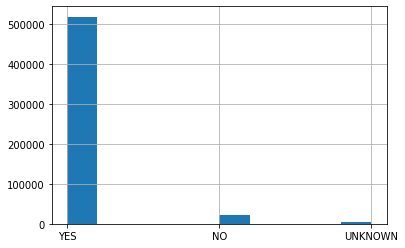

In [8]:
pcs['mental_illness'].hist()

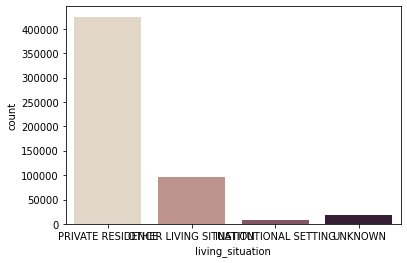

In [9]:
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

The overwheming majority huh......

In [10]:
pcs['age_group'].value_counts(normalize=True)

ADULT      0.797600
CHILD      0.202241
UNKNOWN    0.000159
Name: age_group, dtype: float64

Children account for approximately 18 percent of mental illness patients

In [11]:
pcs['sex'].value_counts(normalize=True)

FEMALE     0.500055
MALE       0.493226
UNKNOWN    0.006719
Name: sex, dtype: float64

In [12]:
pcs['race'].value_counts(normalize=True)

WHITE ONLY      0.509215
BLACK ONLY      0.259497
OTHER           0.169386
UNKNOWN RACE    0.030992
MULTI-RACIAL    0.030910
Name: race, dtype: float64

In [13]:
pcs['hispanic_ethnicity'].value_counts(normalize=True)

NO, NOT HISPANIC/LATINO    0.746384
YES, HISPANIC/LATINO       0.154860
YES                        0.075366
UNKNOWN                    0.023389
Name: hispanic_ethnicity, dtype: float64

In [14]:
pcs['serious_mental_illness'].value_counts(normalize=True)

YES        0.843141
NO         0.150147
UNKNOWN    0.006712
Name: serious_mental_illness, dtype: float64

Strangely enough, 84.3 percent of respondants have a serious mental illness, along with 94.9 percent who havve a mental illness. * note this is a data leakage issue in future modeling 

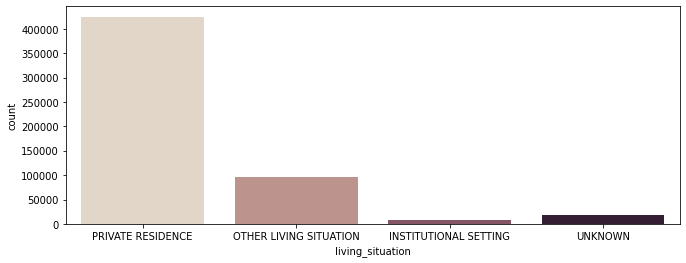

In [15]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

In [16]:
pcs['living_situation'].value_counts(normalize=True)

PRIVATE RESIDENCE         0.776853
OTHER LIVING SITUATION    0.176370
UNKNOWN                   0.032784
INSTITUTIONAL SETTING     0.013993
Name: living_situation, dtype: float64

Most live in a private residence, but the second largest feature is other. With little info on that, I become curious as to the true state of 20% of the respondants

Text(0, 0.5, 'Living Status')

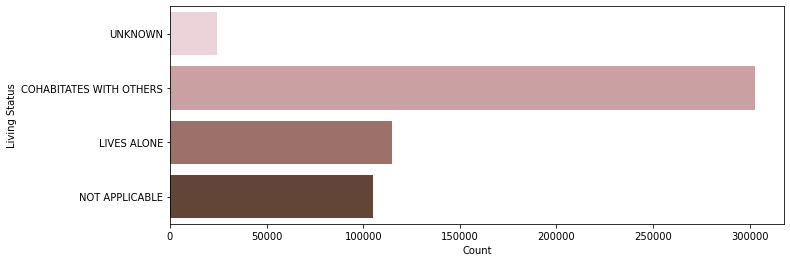

In [17]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
sns.countplot(y="household_composition", palette="ch:1.3,-.2,dark=.3", data=pcs, )
plt.xlabel("Count")
plt.ylabel("Living Status")

Text(0, 0.5, 'Employment Status')

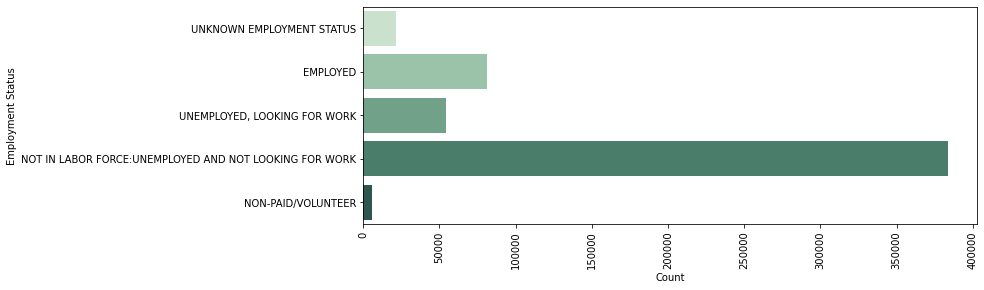

In [18]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
plt.xticks(rotation='vertical')
sns.countplot(y="employment_status", palette="ch:2.5,-.2,dark=.3", data=pcs)
plt.xlabel("Count")
plt.ylabel("Employment Status")

In [19]:
pcs['three_digit_residence_zip_code'].value_counts(normalize=True)

112    0.143071
104    0.108854
100    0.087152
117    0.042738
113    0.041494
142    0.037130
114    0.035517
999    0.035347
146    0.029386
888    0.028396
105    0.024910
115    0.021689
103    0.020161
125    0.018174
140    0.018103
148    0.017133
130    0.015678
132    0.015607
109    0.015537
120    0.013427
107    0.012536
145    0.012264
144    0.012112
116    0.011945
136    0.011830
134    0.010430
129    0.010381
121    0.009962
147    0.009910
128    0.009437
124    0.008353
119    0.007806
122    0.007744
111    0.007080
141    0.006937
131    0.006877
135    0.006545
123    0.006130
138    0.006128
126    0.005978
149    0.005945
110    0.005848
127    0.005810
133    0.005277
143    0.005274
139    0.005131
106    0.005113
137    0.004555
108    0.004015
118    0.001576
101    0.001568
Name: three_digit_residence_zip_code, dtype: float64

In [20]:
 l = pcs['three_digit_residence_zip_code'].value_counts(normalize=True)

In [21]:
l.head(2).sum()

0.2519250053065736

Almost 25% of the group are accounted for with two zipcodes. With a wikipedia search, we see that comprises Brooklyn and The Bronx.

In [22]:
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [23]:
pcs.serious_mental_illness.value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
title='Number complaints in each product')

In [24]:
pcs['id'] = [ uuid.uuid1()  for k in pcs.index]

In [25]:
target = 'serious_mental_illness'
X = pd.DataFrame(pcs.drop(columns=[target,'mental_illness']))
y = pd.DataFrame(pcs[target])

In [26]:
pcs.shape

(546492, 69)

In [27]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, 
    y, 
    test_size=0.001,
    train_size=0.10, 
    stratify=y, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, 
    y_trainval, 
    test_size=0.05,
    train_size=0.10, 
    stratify=y_trainval, 
    random_state=42
)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (5464, 67)
y_train shape (5464, 1)
X_val shape (2733, 67)
y_val shape (2733, 1)
X_test shape (547, 67)
y_test shape (547, 1)


In [28]:
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

In [29]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [30]:
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

In [31]:
def prepare_targets(y_train, y_val,y_test):
    le = ce.OrdinalEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_val_enc = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_val_enc, y_test_enc

In [32]:
y_train_processed, y_val_processed, y_test_processed  = prepare_targets(y_train, y_val, y_test)

In [33]:
eval_set = [(X_train_processed, y_train_processed), (X_val_processed, y_val_processed)]

In [34]:
xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

In [35]:
grid_search = GridSearchCV(estimator=xgbcl, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_processed, y_train_processed)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

[00:01:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best: 0.8543195387069544 using {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.75} 



In [55]:
xgbcl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='multi:softmax', num_class=3,random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         colsample_bytree = grid_result.best_params_['colsample_bytree'], 
         learning_rate = grid_result.best_params_['learning_rate'], 
         max_depth = grid_result.best_params_['max_depth'], 
         subsample = grid_result.best_params_['subsample'], 
         n_estimators = grid_result.best_params_['n_estimators'])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=xgbcl, X=X_train_processed, y=y_train_processed, cv=kfold, scoring=['accuracy', ], n_jobs=-1)




In [56]:
print('Training 5-fold Cross Validation Results:\n')
# print('AUC: ', scores['test_roc_auc'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())
# print('Precision: ', scores['test_precision'].mean())
# print('Recall: ', scores['test_recall'].mean())
# print('F1: ', scores['test_f1'].mean(), '\n')

Training 5-fold Cross Validation Results:

Accuracy:  0.8539540666713584


In [66]:
X_train_processed

array([[2.017e+03, 1.000e+00, 1.000e+00, ..., 9.990e+02, 1.000e+00,
        1.000e+00],
       [2.013e+03, 1.000e+00, 1.000e+00, ..., 1.480e+02, 1.000e+00,
        2.000e+00],
       [2.017e+03, 1.000e+00, 2.000e+00, ..., 1.170e+02, 2.000e+00,
        3.000e+00],
       ...,
       [2.017e+03, 3.000e+00, 3.000e+00, ..., 1.040e+02, 3.000e+00,
        5.462e+03],
       [2.015e+03, 1.000e+00, 2.000e+00, ..., 1.170e+02, 2.000e+00,
        5.463e+03],
       [2.015e+03, 1.000e+00, 1.000e+00, ..., 1.460e+02, 1.000e+00,
        5.464e+03]])

In [61]:
from sklearn import metrics

xgbcl.fit(X_train_processed, y_train_processed)

#Generate predictions against our training and test data
pred_train = xgbcl.predict(X_train_processed)
proba_train = xgbcl.predict_proba(X_train_processed)
pred_test = xgbcl.predict(X_val_processed)
proba_test = xgbcl.predict_proba(X_val_processed)

# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_val_processed, pred_test))

print ('\nTrain Accuracy:', metrics.accuracy_score(y_train_processed, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_val_processed, pred_test))



[14:26:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification report (Test): 

              precision    recall  f1-score   support

           1       0.68      0.14      0.23       411
           2       0.86      0.99      0.92      2304
           3       0.87      0.72      0.79        18

    accuracy                           0.86      2733
   macro avg       0.80      0.62      0.65      2733
weighted avg       0.84      0.86      0.82      2733


Train Accuracy: 0.9050146412884333
Test Accuracy: 0.8594950603732162


In [63]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [64]:
features = ['race', 'cancer']

interaction = pdp_interact(
    model=xgbcl,
    dataset=X_val_processed,
    model_features=X_val_processed.columns,
    features=features
)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features)

In [36]:

# model = XGBClassifier(    
#     n_estimators=1000,  
#     max_depth=7,       
#     learning_rate=0.5,  
#     n_jobs=-1
#     )
# model.fit(X_train_processed, y_train_processed, eval_set=eval_set, early_stopping_rounds=10)